<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [2]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [3]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[0] #Normal
test_file = file_path+file[1]
dataset= "Normal"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 358), (11403, 358), (75818, 358))

In [4]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  """
  print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
  
  if (type(label)!=list) & (type(label)!=np.array):
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred)
    auc = metrics.roc_auc_score(y_true,y_pred)
    log_loss = metrics.log_loss(y_true,y_pred)
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])


    
    

  else:
    for y in y_pred:
      if (type(label)!=list) & (type(label)!=np.array):
        fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred)
        auc = metrics.roc_auc_score(y_true,y_pred)
        label = label+' AUC=%.3f'%(auc)
        #plotting tpr vs fpr
        sns.lineplot(fpr,tpr,label=label)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()


  


# Modeling

In [5]:
def find_best_params(model,params,cv=10):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=10,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

# Logistic Regression

In [6]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [7]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    6.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.0min finished


The best auc score was 0.797
The best params were: {'penalty': 'l2', 'fit_intercept': False, 'C': 0.001}
CPU times: user 7.17 s, sys: 1.09 s, total: 8.25 s
Wall time: 3min 3s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Normal dataset 		 



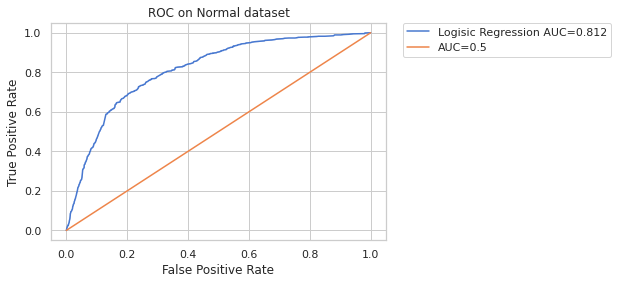

The log loss and auc was found to be 0.542 and 0.812 for Logisic Regression on Normal dataset.


In [9]:
i=0
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

# Decision Trees

In [12]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [13]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  5.7min finished


The best auc score was 0.762
The best params were: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 500, 'max_depth': 10}
CPU times: user 5.23 s, sys: 392 ms, total: 5.62 s
Wall time: 5min 44s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [14]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [15]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=500,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=10,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
           

		 Decision Tree Classifier on Normal dataset 		 



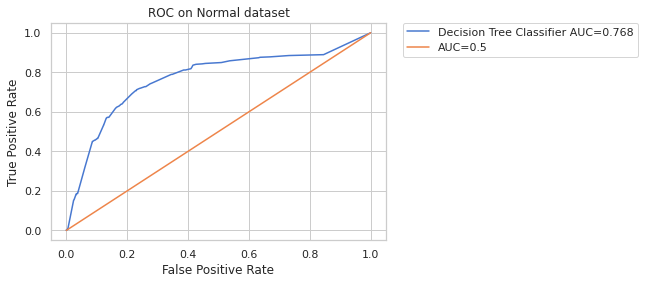

The log loss and auc was found to be 0.150 and 0.768 for Decision Tree Classifier on Normal dataset.


In [16]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [17]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149580,0.767621


# Random Forest

In [19]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,2000], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


In [6]:
#{'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 100, 'max_depth': 1000}
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

#RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
#                        criterion='gini', max_depth=1000, max_features='auto',
#                        max_leaf_nodes=100, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=5, min_samples_split=500,
#                        min_weight_fraction_leaf=0.0, n_estimators=1000,
#                        n_jobs=-1, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [7]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=1000,
                       

		 Random Forest Classifier on Normal dataset 		 



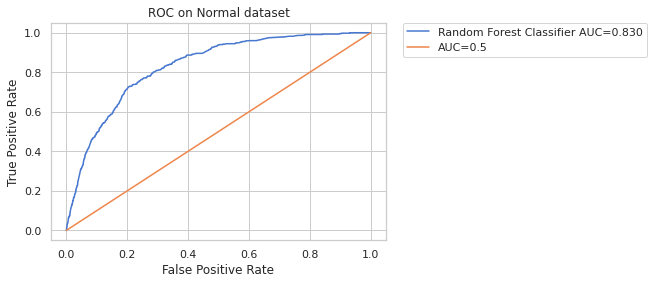

The log loss and auc was found to be 0.138 and 0.830 for Random Forest Classifier on Normal dataset.


In [9]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.538715,0.809177
1,Decision Tree Classifier,Normal,0.147555,0.794187


# XGB Classifier

In [6]:
model = xgb.XGBClassifier()
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,-1], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
#{'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 100, 'max_depth': 1000}
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
#                        criterion='gini', max_depth=1000, max_features='auto',
#                        max_leaf_nodes=100, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=5, min_samples_split=500,
#                        min_weight_fraction_leaf=0.0, n_estimators=1000,
#                        n_jobs=-1, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=1000,
                       

		 Random Forest Classifier on Normal dataset 		 



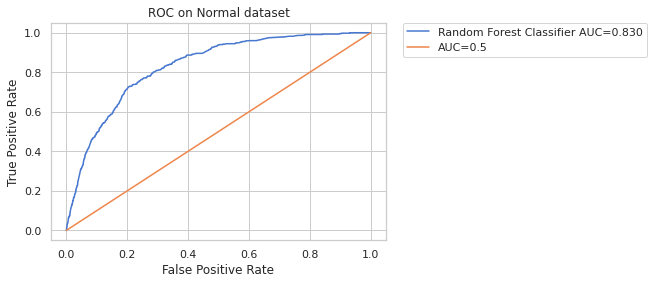

The log loss and auc was found to be 0.138 and 0.830 for Random Forest Classifier on Normal dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.538715,0.809177
1,Decision Tree Classifier,Normal,0.147555,0.794187
